# Project Introduction

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

    Artist Name - Genre:
- Regal - Hip-Hop
- Red Tone - Punk
- Meteor and the Girls - Pop
- Slim Jim Bites - Blues

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style
%matplotlib inline

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
def show_tables():
    q = '''
    SELECT name, type
    FROM sqlite_master
    WHERE type IN ("table", "view")
    '''
    return run_query(q)
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [5]:
q = '''
WITH 
        tracks_sold AS
            (
            SELECT 
                COUNT(il.quantity) total_tracks_sold,
                (CAST(COUNT(il.quantity) AS FLOAT) / (SELECT COUNT(*) FROM invoice_line) * 100) percent_of_all_tracks,
                g.name genre
            FROM invoice_line il
            INNER JOIN track t 
                ON t.track_id = il.track_id
            INNER JOIN genre g
                ON g.genre_id = t.genre_id
            GROUP BY 3
            ORDER BY 1 DESC
            ),
            
            total_quantity AS
            (
            SELECT CAST(SUM(quantity) AS float) 
            FROM invoice_line
            )
            
SELECT * from tracks_sold
'''

In [6]:
df = run_query(q)
df.set_index('genre', inplace=True)
df

,total_tracks_sold,percent_of_all_tracks
genre,,
Rock,2635,55.392054
Metal,619,13.012403
Alternative & Punk,492,10.342653
Latin,167,3.510616
R&B/Soul,159,3.342443
Blues,124,2.606685
Jazz,121,2.543620
Alternative,117,2.459533
Easy Listening,74,1.555602


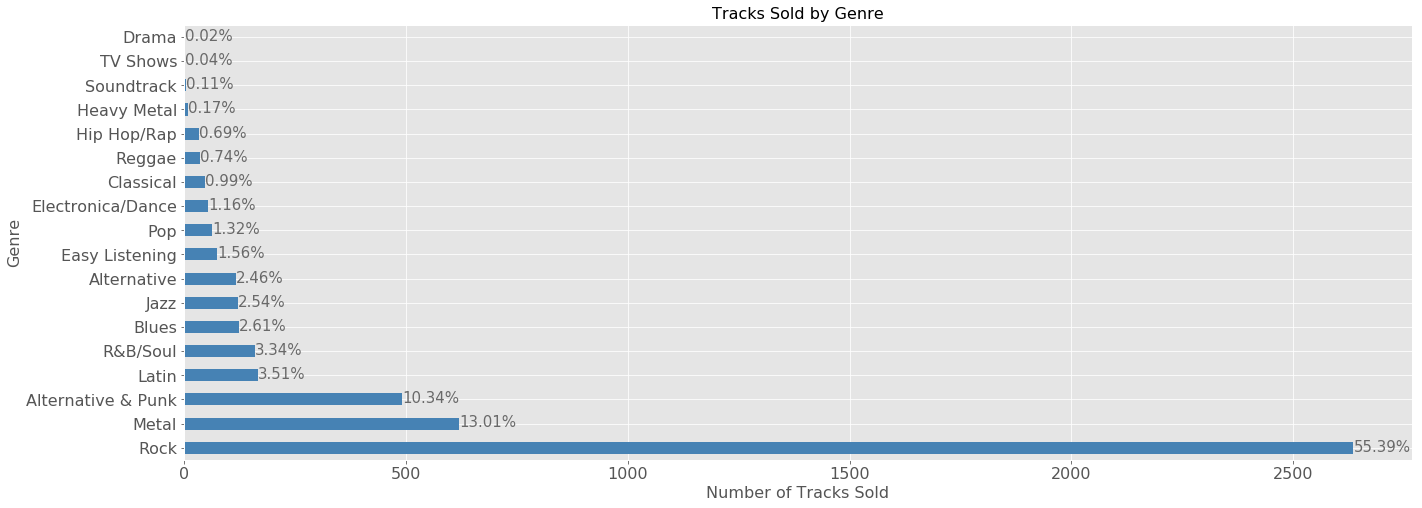

In [7]:
ax = df['total_tracks_sold'].plot(kind='barh', figsize=(22,8), color='steelblue', fontsize=16, legend=None)
plt.xlabel('Number of Tracks Sold', fontsize=16)
plt.ylabel('Genre', fontsize=16)
plt.title('Tracks Sold by Genre', fontsize=16)

ax.set_xticks([0, 500, 1000, 1500, 2000, 2500])

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.1, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='dimgrey')

plt.show()

Based off of the new record label deal and the four new artists to choose from in the project introduction I would choose the next three albums to add to the store form the following artists, in the following order:

1. Red Tone - Punk
2. Slim Jim Bites - Blues
3. Meteor and the Girls - Pop

It's worth noting that of those three artists, their respective genres account for a combined total of only 14.27% of all in-store sales, so signing deals and with record labels who offer albums from artists in the Rock genre should be a higher priority, as that genre accounts for more than three times the sales (55.39%) from the combined three genres in the list above.

# Part 2:
## Analyzing performance of sales support agents

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [8]:
q2 = '''
WITH support_rep_total AS
    (
    SELECT
        SUM(i.total) total, 
        c.support_rep_id support_rep_id
    FROM invoice i
    LEFT JOIN customer c ON c.customer_id = i.customer_id
    GROUP BY support_rep_id
    ORDER BY total
    )
SELECT 
    e.first_name || ' ' || e.last_name employee_name,
    e.hire_date,
    s.total total
FROM employee e
INNER JOIN support_rep_total s 
ON s.support_rep_id = e.employee_id
GROUP BY employee_name
ORDER BY total DESC
'''

In [9]:
df2 = run_query(q2)
df2.set_index('employee_name', inplace=True)
df2

,hire_date,total
employee_name,,
Jane Peacock,2017-04-01 00:00:00,1731.51
Margaret Park,2017-05-03 00:00:00,1584.00
Steve Johnson,2017-10-17 00:00:00,1393.92


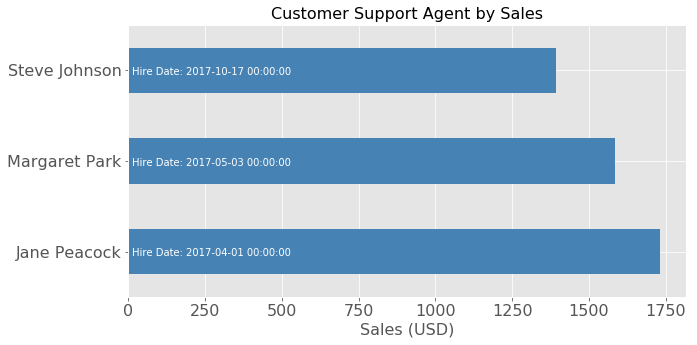

In [10]:
ax = df2['total'].plot(kind='barh', figsize=(10,5), color='steelblue', fontsize=16)
plt.xlabel('Sales (USD)', fontsize=16)
plt.ylabel('', fontsize=16)
plt.title('Customer Support Agent by Sales', fontsize=16)

# annotate value labels to each sales rep
plt.annotate('Hire Date: ' + str(df2['hire_date'].iloc[0]), xy=(10, -.05), color='white')
plt.annotate('Hire Date: ' + str(df2['hire_date'].iloc[1]), xy=(10, .95), color='white')
plt.annotate('Hire Date: ' + str(df2['hire_date'].iloc[2]), xy=(10, 1.95), color='white')

plt.show()

As you can see from the bar chart above the number of sales roughly corresponds to the hire date, ie: the earlier the higher date the higher number of sales.

# Part 3:
## Analyzing sales data for customers from each different country.

In [11]:
c = '''
CREAT VIEW 1_customer_countries AS
    SELECT
'''

In [12]:
q3 = '''
WITH sales_per_country AS
    (
    SELECT
        country dist_country,
        COUNT(*) customers
    FROM customer
    GROUP BY dist_country
    ORDER BY customers
    ),
    
    avg_order_per_country AS
    (
    SELECT 
        SUM(total)/COUNT(invoice_id) avg_order_amount,
        billing_country
    FROM invoice
    GROUP BY billing_country
    ORDER BY avg_order_amount
    ),
    
    all_countries AS
    (
    SELECT 
        SUM(i.total) total_sales,
        s.dist_country,
        s.customers,
        SUM(i.total)/s.customers avg_sales_per_customer,
        a.avg_order_amount
    FROM invoice i
    INNER JOIN sales_per_country s 
        ON s.dist_country = i.billing_country
    INNER JOIN avg_order_per_country a
        ON a.billing_country = s.dist_country
    GROUP BY dist_country
    ORDER BY total_sales DESC
    ),
    
    countries_w_other_cat AS (
    SELECT 
        SUM(customers) customers,
        CASE
            WHEN customers = 1 THEN 'Other'
            ELSE dist_country
        END AS country,
        SUM(total_sales) total_sales,
        customers,
        avg_sales_per_customer,
        avg_order_amount
        FROM all_countries
    GROUP BY country
    ORDER BY total_sales DESC
    )
    
SELECT
    country,
    customers,
    total_sales,
    avg_order,
    avg_cust_sales
FROM (
    SELECT
        country,
        customers,
        total_sales,
        avg_order_amount avg_order,
        avg_sales_per_customer avg_cust_sales,
        CASE
            WHEN country = 'Other' THEN 1
            ELSE 0
        END AS sort
    FROM countries_w_other_cat
    ORDER BY SORT
    )
'''

In [13]:
df3 = run_query(q3)
df3

,country,customers,total_sales,avg_order,avg_cust_sales
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,3.762000,37.620000


In [17]:
df3.set_index('country', inplace=True)
df3

,customers,total_sales,avg_order,avg_cust_sales
country,,,,
USA,13,1040.49,7.942672,80.037692
Canada,8,535.59,7.047237,66.948750
Brazil,5,427.68,7.011148,85.536000
France,5,389.07,7.781400,77.814000
Germany,4,334.62,8.161463,83.655000
Czech Republic,2,273.24,9.108000,136.620000
United Kingdom,3,245.52,8.768571,81.840000
Portugal,2,185.13,6.383793,92.565000
India,2,183.15,8.721429,91.575000


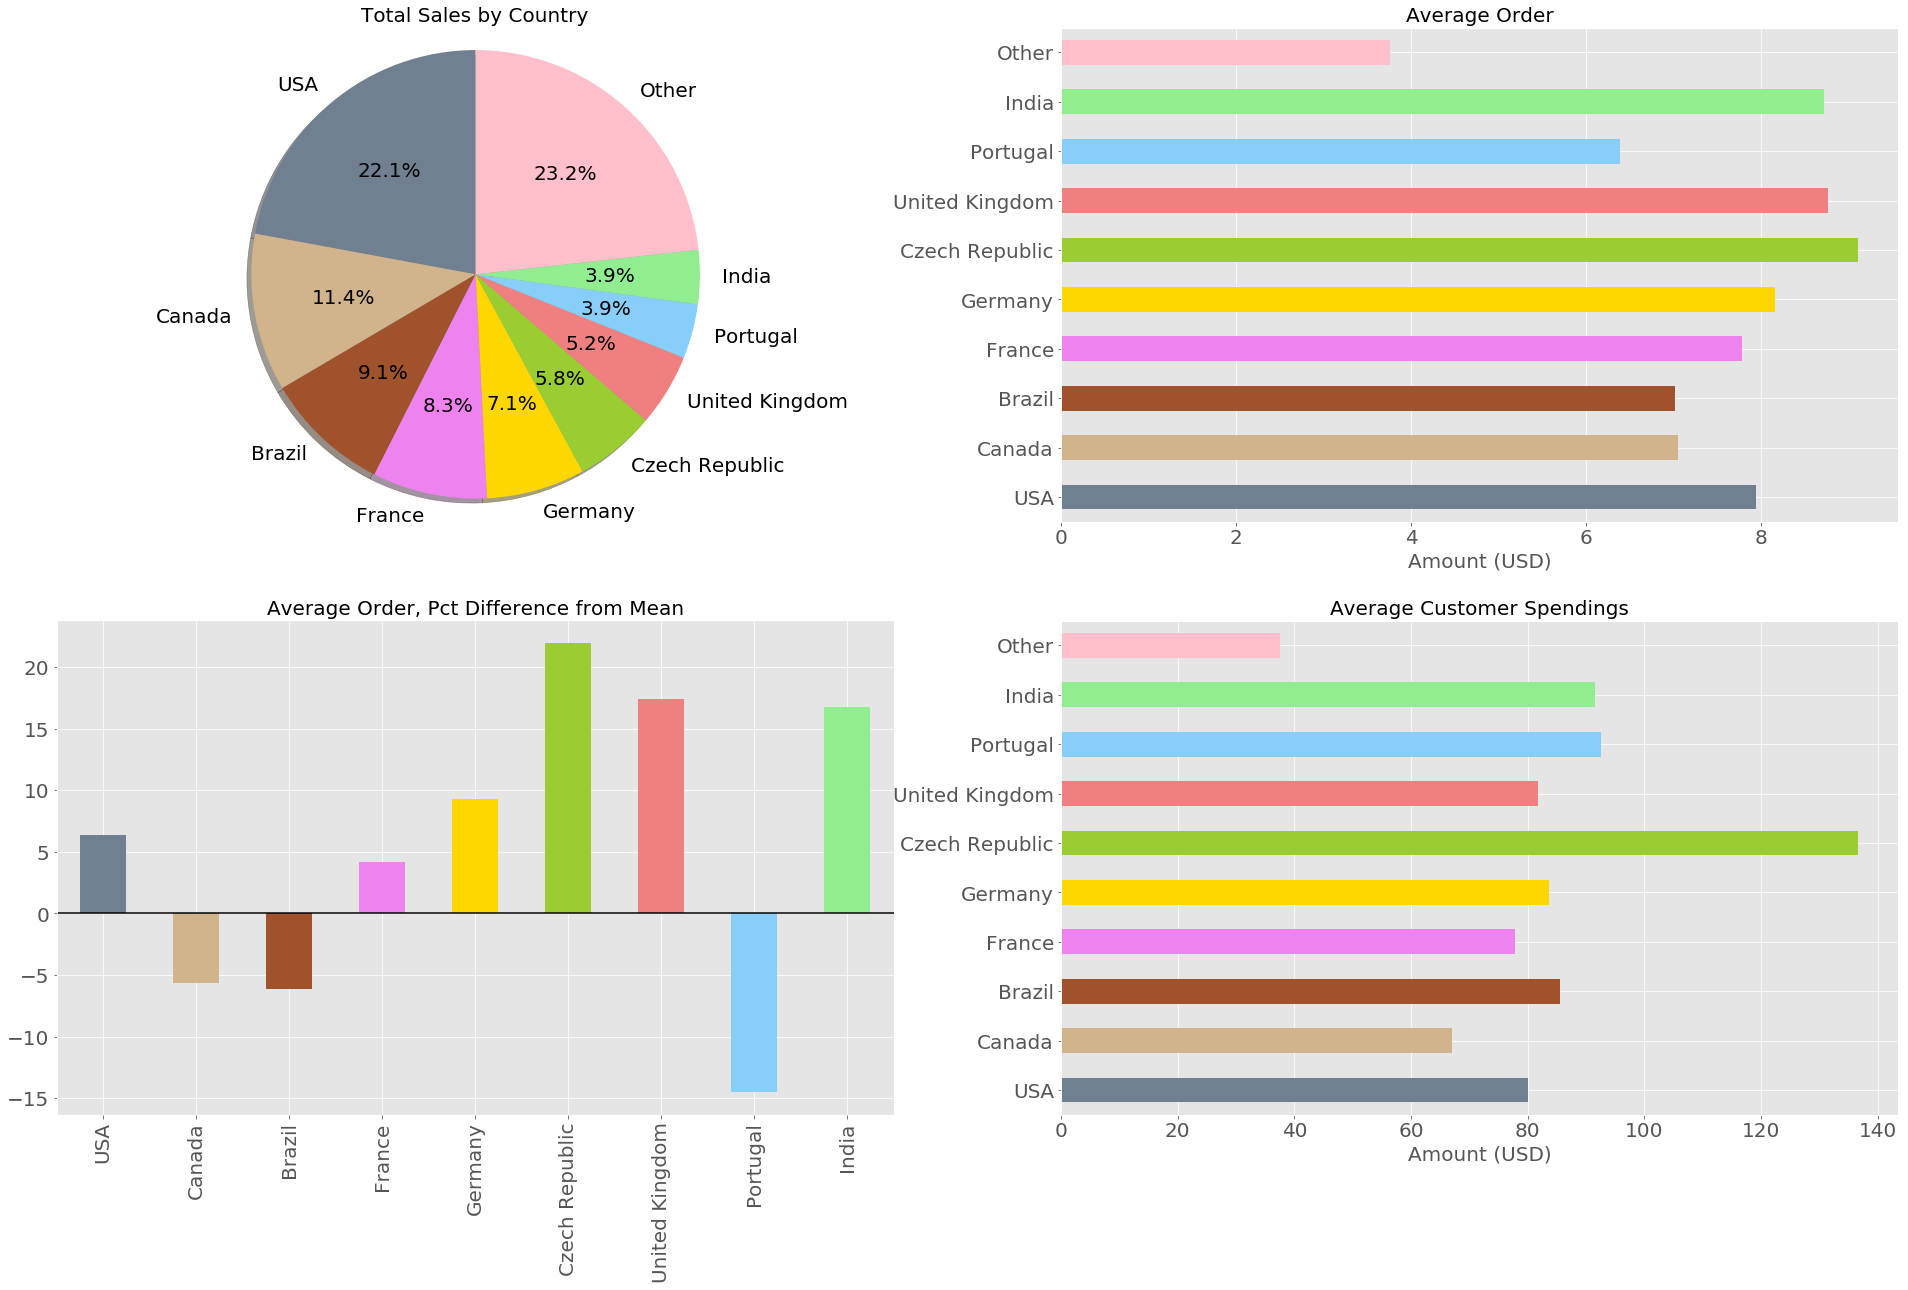

In [20]:
# now lets show multiple plots on the same figure

fig = plt.figure(figsize=(33,20)) # create figure

ax0 = fig.add_subplot(2, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(2, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)

# Subplot 1: Box plot
colors_list = ['slategrey', 'tan', 'sienna', 'violet', 'gold', 'yellowgreen', 
               'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
# to see a full list of available colors, run: for name, hex in mpl.colors.cnames.items(): print(name, hex)

explode_list = [0.1, 0, 0, 0, 0.1, 0.1] # ratio for each continent with which to offset each wedge.

df3['total_sales'].plot(kind='pie', autopct='%1.1f%%',
                            startangle=90, shadow=True,
                            #labels=None, #removes circumfrencial labels
                            #pctdistance=1.12, #moves % from slice to circumference
                            colors=colors_list,
                            ax=ax0,
                            fontsize=20
                            #explode=explode_list #explode lowest 3 continents
                            )

ax0.set_title('Total Sales by Country',fontsize=20)#, y=1.12)#for pctdistance
ax0.axis('equal')
ax0.set_ylabel('')#remove column name 'Total' from left side of figure
#ax0.legend(labels=df3.index, loc='upper left')

# Subplot 2: Line plot
#df_CI.plot(kind='line', figsize=(20, 6), ax=ax1) # add to subplot 2
#ax1.set_title('Line Plots of Immigrants from China and India \n (1980 - 2013)')
#ax1.set_ylabel('Number of Immigrants')
#ax1.set_xlabel('Years')

df3['avg_order'].plot(kind='barh', color=colors_list, fontsize=20, legend=None, ax=ax1)
ax1.set_xlabel('Amount (USD)', fontsize=20)
ax1.set_ylabel('')
ax1.set_title("Average Order",
         fontsize=20)


avg_order = df3["avg_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax2,
    color=colors_list,
    fontsize=20
)
ax2.axhline(0, color='k')
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.set_title("Average Order, Pct Difference from Mean", fontsize=20)

df3['avg_cust_sales'].plot(kind='barh', color=colors_list, fontsize=20, legend=None, ax=ax3)
ax3.set_xlabel('Amount (USD)', fontsize=20)
ax3.set_ylabel('')
ax3.set_title("Average Customer Spendings",
         fontsize=20)


plt.show()

Based on the data, there may be opportunity in the following countries:

- Czech Republic
- India
- United Kingdom
- Portugal

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

# Part 3

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

Write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:

- Number of invoices
- Percentage of invoices

Write one to two sentences explaining your findings, and making a prospective recommendation on whether the Chinook store should continue to buy full albums from record companies

In [21]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Since nearly a fifth of sales are from album purchases I would recommend to continue purchasing full albums instead of just the most popular tracks. The only way this would increase profit is if the store would save more than 18.6% of it's entire revenue by purchasing only the most popular tracks.